In [1]:
# can comment out after executing
cd /content/


/content


In [2]:
!unzip datafordcgan.zip

Archive:  datafordcgan.zip
   creating: data/
   creating: data/male/
   creating: data/male/train/
 extracting: data/male/train/1.png   
 extracting: data/male/train/10.png  
 extracting: data/male/train/100.png  
 extracting: data/male/train/1000.png  
 extracting: data/male/train/1001.png  
 extracting: data/male/train/1002.png  
 extracting: data/male/train/1003.png  
 extracting: data/male/train/1004.png  
 extracting: data/male/train/1005.png  
 extracting: data/male/train/1006.png  
 extracting: data/male/train/101.png  
 extracting: data/male/train/102.png  
 extracting: data/male/train/103.png  
 extracting: data/male/train/104.png  
 extracting: data/male/train/105.png  
 extracting: data/male/train/106.png  
 extracting: data/male/train/107.png  
 extracting: data/male/train/108.png  
 extracting: data/male/train/109.png  
 extracting: data/male/train/11.png  
 extracting: data/male/train/110.png  
 extracting: data/male/train/111.png  
 extracting: data/male/train/112.png  

In [3]:
import torch
torch.__version__
torch.version.cuda  #9.0
torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.get_device_properties(0)
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.current_device()    # 当前正在使用的设备
 
torch.backends.cudnn.version()   # 7005,查看cudnn的版本


7603

In [0]:
from unittest.mock import MagicMock, patch
import numpy as np
import torch


def _print_success_message():
    print('Tests Passed')


class AssertTest(object):
    def __init__(self, params):
        self.assert_param_message = '\n'.join([str(k) + ': ' + str(v) + '' for k, v in params.items()])

    def test(self, assert_condition, assert_message):
        assert assert_condition, assert_message + '\n\nUnit Test Function Parameters\n' + self.assert_param_message
        

def test_discriminator(Discriminator):
    batch_size = 50
    conv_dim=10
    D = Discriminator(conv_dim)

    # create random image input
    x = torch.from_numpy(np.random.randint(1, size=(batch_size, 3, 128, 128))*2 -1).float()
    
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        x.cuda()

    output = D(x)
    assert_test = AssertTest({
        'Conv Dim': conv_dim,
        'Batch Size': batch_size,
        'Input': x})

    correct_output_size = (batch_size, 1)
    assert_condition = output.size() == correct_output_size
    assert_message = 'Wrong output size. Expected type {}. Got type {}'.format(correct_output_size, output.size())
    assert_test.test(assert_condition, assert_message)

    _print_success_message()
    
def test_generator(Generator):
    batch_size = 50
    z_size = 25
    conv_dim=10
    G = Generator(z_size, conv_dim)

    # create random input
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        z.cuda()
    #b = torch.LongTensor(a)
    #nn_input = torch.autograd.Variable(b)

    output = G(z)
    assert_test = AssertTest({
        'Z size': z_size,
        'Conv Dim': conv_dim,
        'Batch Size': batch_size,
        'Input': z})

    correct_output_size = (batch_size, 3, 128, 128)
    assert_condition = output.size() == correct_output_size
    assert_message = 'Wrong output size. Expected type {}. Got type {}'.format(correct_output_size, output.size())
    assert_test.test(assert_condition, assert_message)

    _print_success_message()

In [0]:
data_dir = '/content/data/male'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import init

#import helper

%matplotlib inline

In [0]:
import torch
from torchvision import datasets
from torchvision import transforms

In [0]:
def get_dataloader(batch_size, image_size, data_dir='/content/data/male'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()]) 
    image_dataset = datasets.ImageFolder(data_dir, transform)
    return torch.utils.data.DataLoader(image_dataset, batch_size = batch_size, shuffle=True)

In [0]:
# Define function hyperparameters
batch_size = 64
img_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

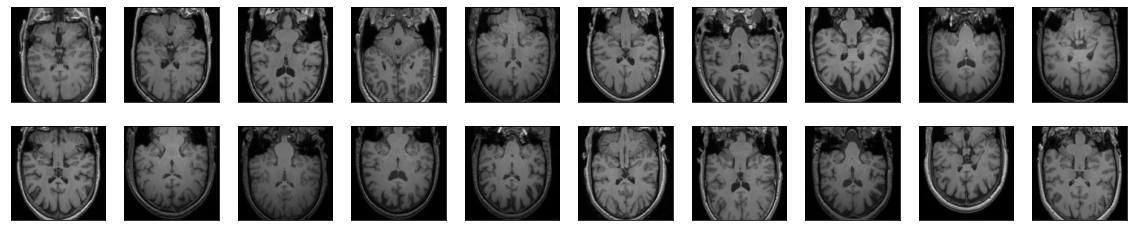

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min, max = feature_range
    x= x * (max - min) + min
    return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8902)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding = 1, batch_norm= True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                       kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        
        self.fc = nn.Linear(conv_dim*1024, 1)
        #self.out = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)   
        x = x.view(-1, self.conv_dim*1024)       
        x = self.fc(x)
        x = self.dropout(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#test_discriminator(Discriminator)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*1024)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4 )
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x1 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        x = self.dropout(x)
        x = x.view(-1, self.conv_dim*4, 16, 16)    
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = torch.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_generator(Generator)

Tests Passed


In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    # TODO: Apply initial weights to convolutional and linear layers
    init_gain=0.02
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1: 
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [16]:

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=65536, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=65536, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kern

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [0]:
import random
from random import randrange, uniform

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * np.random.uniform(0.7, 1.2)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) * np.random.uniform(0.0, 0.3)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
import torch.optim as optim
lr = 0.0003
beta1= 0.1
beta2= 0.99
# Create optimizers for the discriminator D and generator G
#d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
#g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
d_optimizer = optim.RMSprop(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [0]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    #print(fixed_z.shape)
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            #print(batch_size)
            #print(real_images.shape)
            real_images = scale(real_images)
            #print(real_images.shape)
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
         # 1. Train the discriminator on real and fake images
            for d_index in range(10):
              d_optimizer.zero_grad()
              
              if train_on_gpu:
                  real_images = real_images.cuda()
              
              d_out = D(real_images)
              #print(d_out)
              #d_real_loss = real_loss(d_out)
              d_real_loss = -torch.mean(d_out)
              #d_real_loss.backward() 
              z = np.random.uniform(-1, 1, size=(batch_size, z_size))
              z = torch.from_numpy(z).float()
              if train_on_gpu:
                  z = z.cuda()               
              fake_images = G(z)
              
              d_fake_out = D(fake_images)
              #d_fake_loss = fake_loss(d_fake_out)
              d_fake_loss = torch.mean(d_fake_out)
              #d_fake_loss.backward()
              d_loss = d_real_loss + d_fake_loss
              
              d_loss.backward()
              d_optimizer.step()

              for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)

            # 2. Train the generator with an adversarial loss   
            for g_index in range(1):         
              g_optimizer.zero_grad()
              
              z = np.random.uniform(-1, 1, size=(batch_size, z_size))
              z = torch.from_numpy(z).float()

              if train_on_gpu:
                  z = z.cuda()
                  
              fake_images = G(z)
              g_fake_out = D(fake_images)
              #g_loss = real_loss(g_fake_out)
              g_loss = -torch.mean(g_fake_out)
              g_loss.backward()
              g_optimizer.step() 
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [23]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: -6.1347 | g_loss: 1.4943
Epoch [    2/  100] | d_loss: -7.6773 | g_loss: 3.0325
Epoch [    3/  100] | d_loss: -6.9945 | g_loss: 3.2650
Epoch [    4/  100] | d_loss: -6.6026 | g_loss: 1.4567
Epoch [    5/  100] | d_loss: -7.5116 | g_loss: 3.1723
Epoch [    6/  100] | d_loss: -7.0089 | g_loss: 2.0638
Epoch [    7/  100] | d_loss: -6.0564 | g_loss: 3.4241
Epoch [    8/  100] | d_loss: -7.5379 | g_loss: 3.1922
Epoch [    9/  100] | d_loss: -6.8952 | g_loss: 3.3568
Epoch [   10/  100] | d_loss: -7.4245 | g_loss: 2.9172
Epoch [   11/  100] | d_loss: -6.2778 | g_loss: 2.3594
Epoch [   12/  100] | d_loss: -5.7255 | g_loss: 2.7975
Epoch [   13/  100] | d_loss: -5.5455 | g_loss: 2.9107
Epoch [   14/  100] | d_loss: -6.4857 | g_loss: 2.2550
Epoch [   15/  100] | d_loss: -5.6940 | g_loss: -0.1151
Epoch [   16/  100] | d_loss: -6.9312 | g_loss: 2.7383
Epoch [   17/  100] | d_loss: -7.5665 | g_loss: 2.9657
Epoch [   18/  100] | d_loss: -6.6227 | g_loss: 1.4593
Epoch [  

In [0]:
!nvidia-smi

Sun Apr 26 02:24:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    37W / 250W |  16263MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

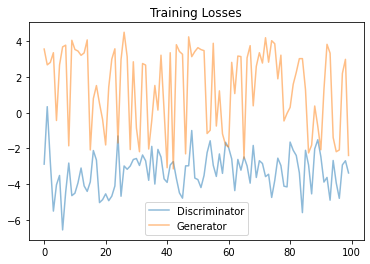

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((128,128,3)))

In [0]:

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

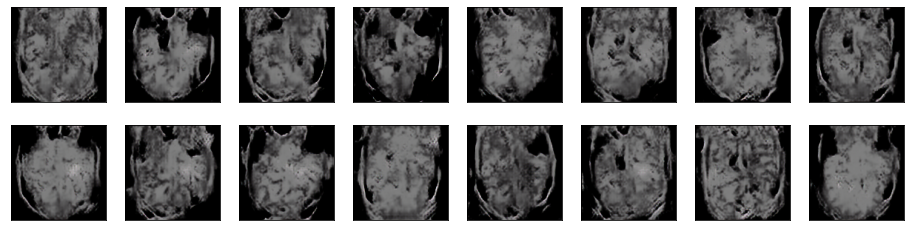

In [0]:

_ = view_samples(-1, samples)